<h1>Jigsaw Unintended Bias in Toxicity Classification.</h1>

<h3>Detect toxicity across a diverse range of conversations</h3>

Ref : https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification

<h2> Description</h2>

###### The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

###### Here’s the background:  When the Conversation AI team first built toxicity models, they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted a high likelihood of toxicity for comments containing those identities (e.g. "gay"), even when those comments were not actually toxic (such as "I am a gay woman"). This happens because training data was pulled from available sources where unfortunately, certain identities are overwhelmingly referred to in offensive ways. Training a model from data with these imbalances risks simply mirroring those biases back to users.

<h2>Data information</h2>

<h6>At the end of 2017 the Civil Comments platform shut down and chose make their ~2m public comments from 
    their platform available in a lasting open archive so that researchers could understand and improve 
    civility in online conversations for years to come. Jigsaw sponsored this effort and extended annotation 
    of this data by human raters for various toxic conversational attributes.


In the data supplied for this competition, the text of the individual comment is found in the comment_text 
column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity for 
the Test data. This attribute (and all others) are fractional values which represent the fraction of human 
raters who believed the attribute applied to the given comment. For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).


The data also has several additional toxicity subtype attributes. Models do not need to predict these 
attributes for the competition, they are included as an additional avenue for research. Subtype attributes 
are:

severe_toxicity

obscene

threat

insult

identity_attack

sexual_explicit

Additionally, a subset of comments have been labelled with a variety of identity attributes, representing the identities that are mentioned in the comment. The columns corresponding to identity attributes are listed below. Only identities with more than 500 examples in the test set (combined public and private) will be included in the evaluation calculation. These identities are shown in bold.
#### male
#### female
transgender
other_gender
heterosexual
#### homosexual_gay_or_lesbian
bisexual
other_sexual_orientation
#### christian
#### jewish
#### muslim
hindu
buddhist
atheist
other_religion
#### black
#### white
asian
latino
other_race_or_ethnicity
physical_disability
intellectual_or_learning_disability
#### psychiatric_or_mental_illness
other_disability

Note that the data contains different comments that can have the exact same text. Different comments that have the same text may have been labeled with different targets or subgroups.</h6>


<h2>Objective</h2>

##### Build a model that recognizes toxicity and minimizes unintended bias with respect to mentions of identities

<h2>Business Constraints</h2>

<h6> 1. It should have some low -latency requirements, because the model should return the toxicity level and display the warning message before submitting the comment into any online community.</h6>

<h6>2. Interpretability is not that important here.</h6>


<h2>Performance Metric</h2>

<h6>A newly developed ROC-AUC metric that combines several submetrics to balance overall performance with various aspects of unintended bias.</h6>


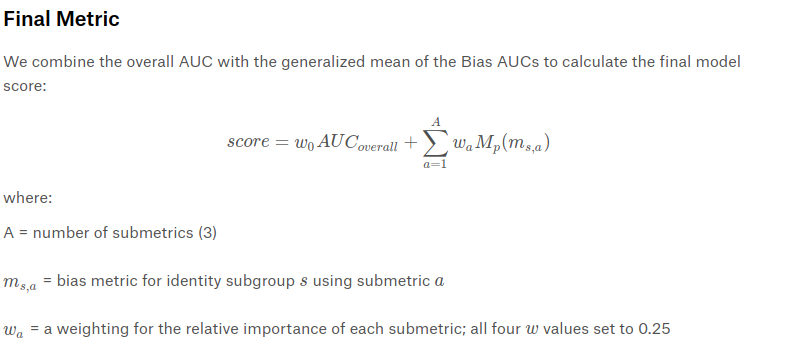


metric reference from kaggle : https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation

Conversation AI's recent paper : https://arxiv.org/abs/1903.04561




In [1]:
#For Data loading and preprocessing
import pandas as pd

#For matrix operations
import numpy as np

#For plotting
import matplotlib.pyplot as plt
import seaborn as sns

#For splitting the data
from sklearn.model_selection import train_test_split

#For data preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#For hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

#For appling models
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

#For model/vatiable persistence 
from sklearn.externals import joblib

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#For math operations
import math 

#To see the progress of the iterations
from tqdm import tqdm

#Performance metrices
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc,log_loss,confusion_matrix

#For ignoring warnings
import warnings
warnings.filterwarnings("ignore")

#For text-preprocessing
from bs4 import BeautifulSoup
import re


/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<h2>Loading the data</h2>

In [2]:
data = pd.read_csv("train.csv")
data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
print("Total points in data:{}".format(data.shape[0]))
print("Total variables in data:{}".format(data.shape[1]))

Total points in data:1804874
Total variables in data:45


In [7]:
#Sorting the entire data based on its date
data = data.sort_values(by ='created_date')
data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


<h2>1. Exploratory Data Analysis </h2>

In [9]:
print("These are the total {} features in the data".format(data.shape[1]))
data.columns.to_list()

These are the total 45 features in the data


['id',
 'target',
 'comment_text',
 'severe_toxicity',
 'obscene',
 'identity_attack',
 'insult',
 'threat',
 'asian',
 'atheist',
 'bisexual',
 'black',
 'buddhist',
 'christian',
 'female',
 'heterosexual',
 'hindu',
 'homosexual_gay_or_lesbian',
 'intellectual_or_learning_disability',
 'jewish',
 'latino',
 'male',
 'muslim',
 'other_disability',
 'other_gender',
 'other_race_or_ethnicity',
 'other_religion',
 'other_sexual_orientation',
 'physical_disability',
 'psychiatric_or_mental_illness',
 'transgender',
 'white',
 'created_date',
 'publication_id',
 'parent_id',
 'article_id',
 'rating',
 'funny',
 'wow',
 'sad',
 'likes',
 'disagree',
 'sexual_explicit',
 'identity_annotator_count',
 'toxicity_annotator_count']

#### From the above all features, it is given that our class label is named with column name "target".  Let's observe this

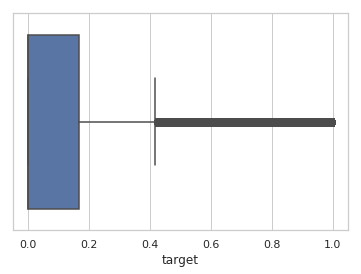

In [6]:
sns.set(style="whitegrid")
#plt.figure(figsize=(6,20))
sns.boxplot(data.target)
plt.show()

#### All "target"  values are squashed between [0,1].  Let's convert into 1 or 0 on keeping thershold 0.5

In [10]:
def unit_step_func(value):
    if value < 0.5:
        return 0
    return 1

In [11]:
data['target'] =data["target"].map(unit_step_func)

#### Checking whether data is balanced or not 

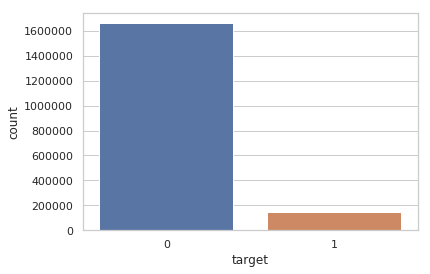

In [9]:
sns.set(style="whitegrid")
#plt.figure(figsize=(20,6))
sns.countplot(data.target)
plt.show()

#### Here we can realize the data is highly imbalanced.

In [12]:
data = data. sort_values(by="created_date")

##### Now let's check metadata features from Jigsaw annotation and civil comments :

"toxicity_annotator_count" 

"identity_annotator_count"

"created_date"

"publication_id"

"parent_id"

"article_id" 

"rating" 

"funny"

"wow"

"sad" 

"likes"

"disagree"

Let understand these varibles are useful or not

<h4>"toxicity_annotator_count":</h4>

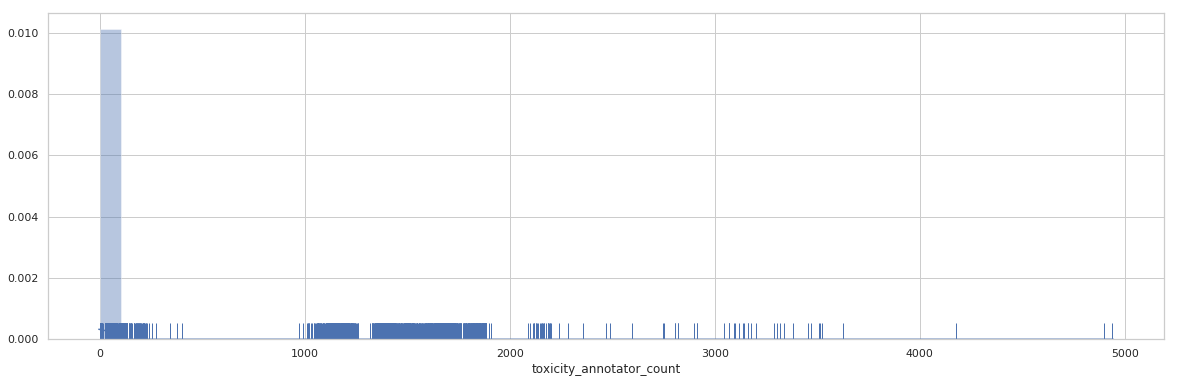

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,6))
sns.distplot(data.toxicity_annotator_count,rug=True, hist=True,kde=True)
plt.show()

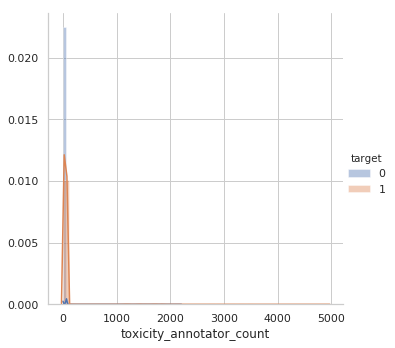

In [14]:
sns.FacetGrid(data, hue="target", size=5) \
   .map(sns.distplot,"toxicity_annotator_count",kde= True) \
   .add_legend();
plt.show();

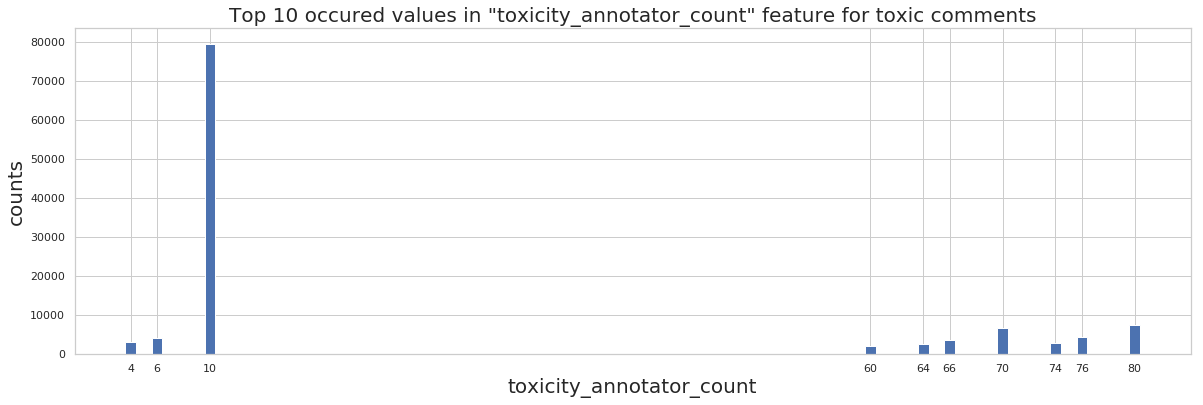

In [18]:
top = 10
y1 = (data[data['target']==1].toxicity_annotator_count.value_counts().head(top)).values
x1 = (data[data['target']==1].toxicity_annotator_count.value_counts().head(top)).index
plt.figure(figsize=(20,6))
plt.bar(x1, y1)
plt.title("Top {} occured values in \"toxicity_annotator_count\" feature for toxic comments".format(top),fontsize=20)
plt.xlabel("toxicity_annotator_count",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.xticks(x1)
plt.show()

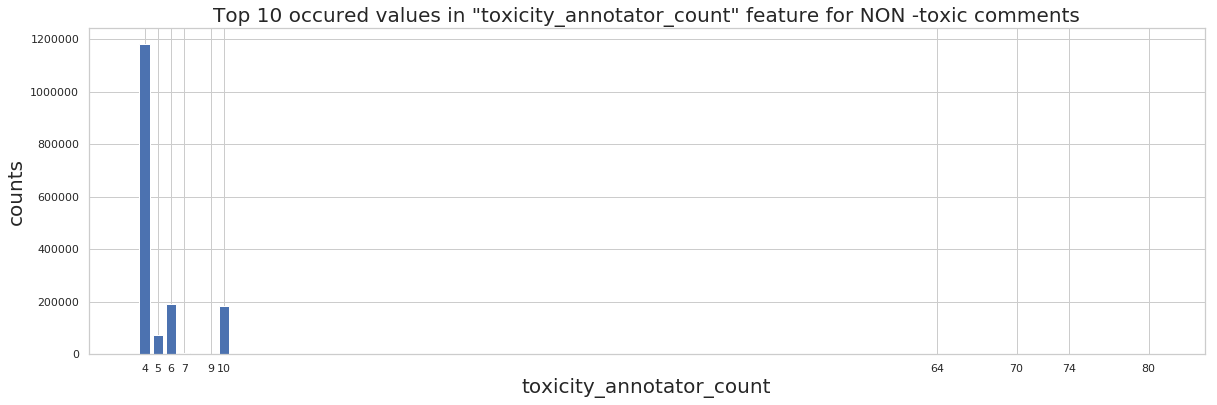

In [19]:
top = 10
y0 = (data[data['target']==0].toxicity_annotator_count.value_counts().head(top)).values
x0 = (data[data['target']==0].toxicity_annotator_count.value_counts().head(top)).index
plt.figure(figsize=(20,6))
plt.bar(x0, y0)
plt.title("Top {} occured values in \"toxicity_annotator_count\" feature for NON -toxic comments".format(top),fontsize=20)
plt.xlabel("toxicity_annotator_count",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.xticks(x0)
plt.show()

##### From the above analysis we can observe that 
1. "toxicity_annotator_count" density is more in between 1 to 10 for all the data points.
2. No data points are founnd with toxicity_annotator_count =0
3. Less annotator count may give less authorization to the toxicity lables, hence removing the points which are less than 4

In [20]:
data= data[data["toxicity_annotator_count"]>=4]

<h4>"identity_annotator_count":</h4>

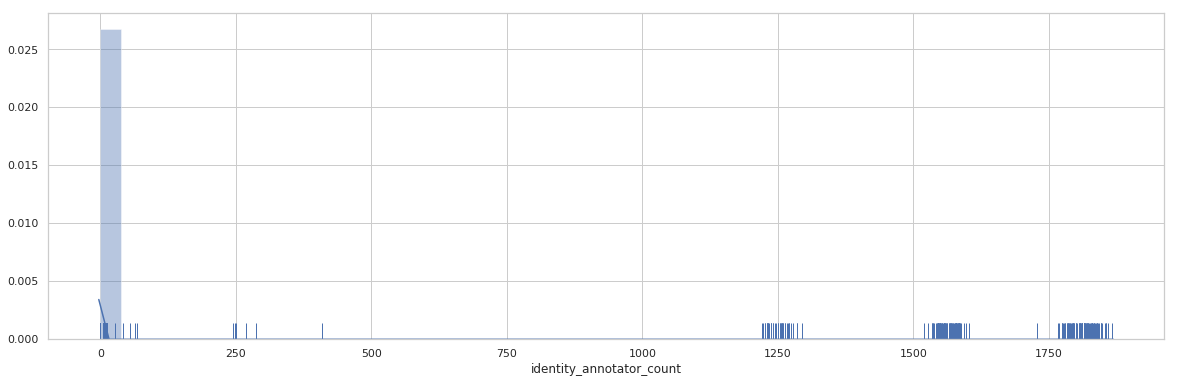

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,6))
sns.distplot(data.identity_annotator_count,rug=True, hist=True,kde=True)
plt.show()

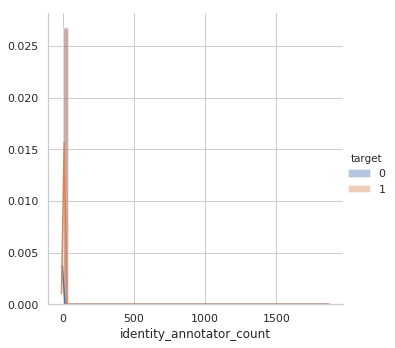

In [22]:
sns.FacetGrid(data, hue="target", size=5) \
   .map(sns.distplot,"identity_annotator_count",kde= True) \
   .add_legend();
plt.show();

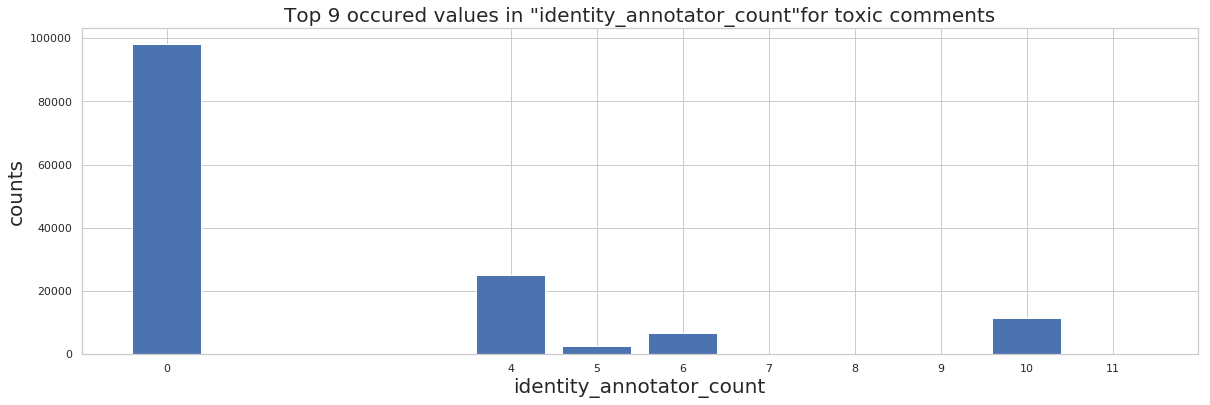

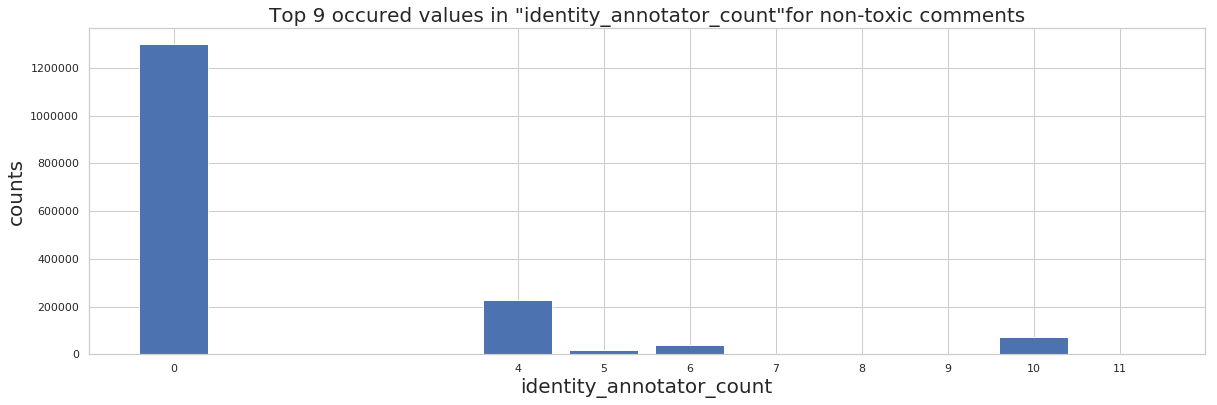

In [23]:
top = 9
y1 = (data[data['target']==1].identity_annotator_count.value_counts().head(top)).values
x1 = (data[data['target']==1].identity_annotator_count.value_counts().head(top)).index
plt.figure(figsize=(20,6))
plt.bar(x1, y1)
plt.title("Top {} occured values in \"identity_annotator_count\"for toxic comments".format(top),fontsize=20)
plt.xlabel("identity_annotator_count",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.xticks(x1)
plt.show()


y0 = (data[data['target']==0].identity_annotator_count.value_counts().head(top)).values
x0 = (data[data['target']==0].identity_annotator_count.value_counts().head(top)).index
plt.figure(figsize=(20,6))
plt.bar(x0, y0)
plt.title("Top {} occured values in \"identity_annotator_count\"for non-toxic comments".format(top),fontsize=20)
plt.xlabel("identity_annotator_count",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.xticks(x0)
plt.show()

#### Most of the points have "identity_annotators_count" = 0,  If we remove those points we will loose too much information 

<h4> "Disagree" and "likes"</h4>

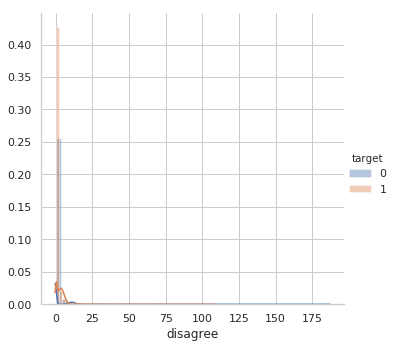

In [24]:
sns.FacetGrid(data, hue="target", size=5) \
   .map(sns.distplot,"disagree",kde= True) \
   .add_legend();
plt.show();

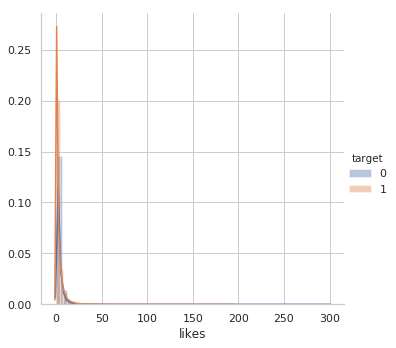

In [25]:
sns.FacetGrid(data, hue="target", size=5) \
   .map(sns.distplot,"likes",kde= True) \
   .add_legend();
plt.show();

#### "disagree" and "likes" are not useful for identifing unwanted points 

#### Now checking sub-target labels and identity labels

##### For a  given "comment_text" the model has to predict its Toxicity,Toxicity subtypes,and its mentioned Identity.

For toxicity we have "target"

Here for Toxicity subtypes we have following labels

1. 'severe_toxicity'
2. 'obscene'
3. 'identity_attack'
4. 'insult'
5. 'threat'
6. 'sexual_explicit'

For identity attributes we are considering only identities with more than 500 examples in the test set (data description from kaggle refer :https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data).

1. male
2. female
3. homosexual_gay_or_lesbian
4. christian
5. jewish
6. muslim
7. black
8. white
9. psychiatric_or_mental_illness


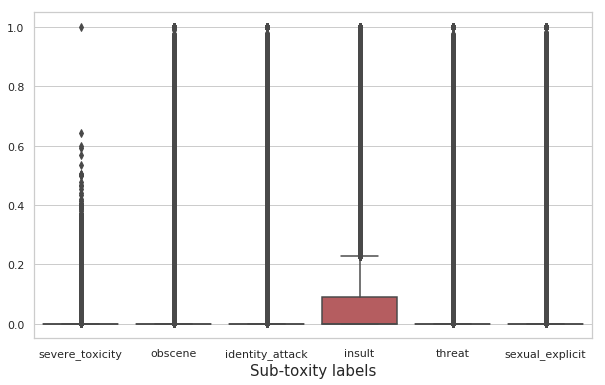

In [30]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['severe_toxicity','obscene','identity_attack','insult','threat','sexual_explicit']])
plt.xlabel("Sub-toxity labels",fontsize=15)
plt.show()

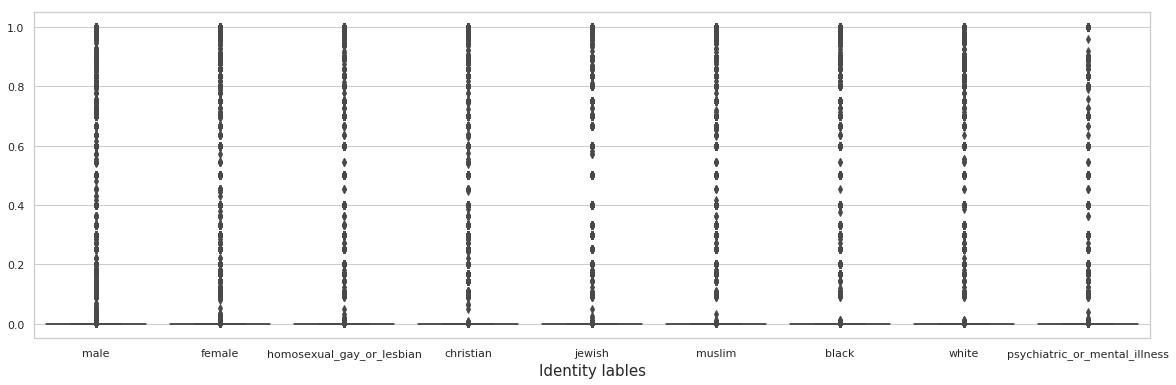

In [34]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.boxplot(data=data[["male","female","homosexual_gay_or_lesbian","christian","jewish","muslim","black","white","psychiatric_or_mental_illness"]])
plt.xlabel("Identity lables",fontsize=15)
plt.show()

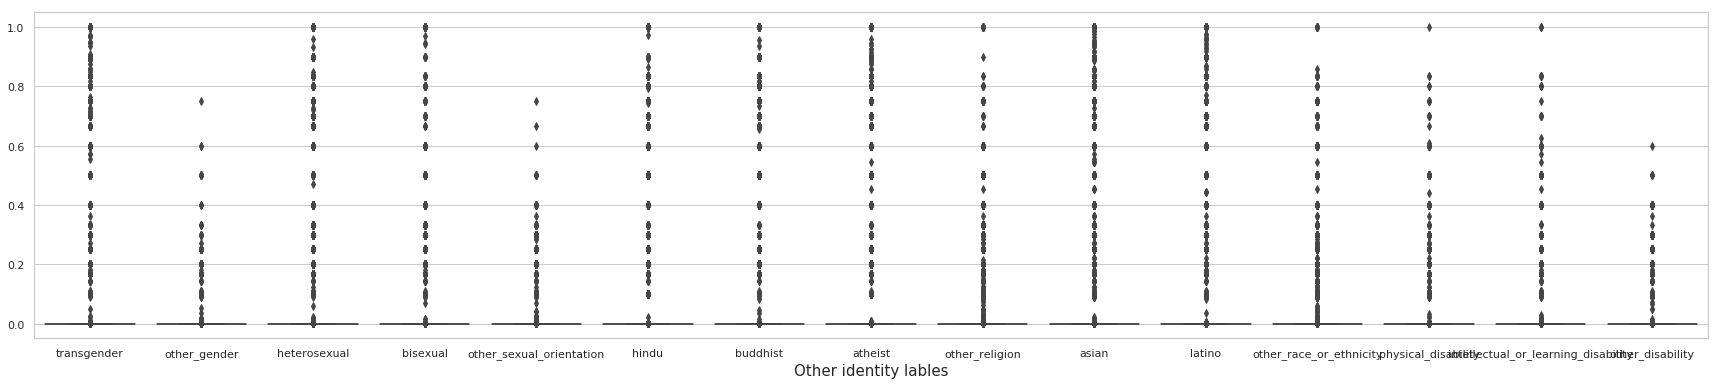

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(30, 6))
sns.boxplot(data=data[["transgender","other_gender","heterosexual","bisexual","other_sexual_orientation",
                      "hindu","buddhist","atheist","other_religion","asian","latino","other_race_or_ethnicity"
                      ,"physical_disability","intellectual_or_learning_disability","other_disability"]])
plt.xlabel("Other identity lables",fontsize=15)
plt.show()

#### Observations:
1. On looking at above box-plots we can say that all label values are squashed between[0,1].
2. In the last plot we can observe that, only a very few points are > 0 .  


##### Keeping only wanted attributes

In [35]:
data = data[["comment_text","target","severe_toxicity","obscene","threat","insult","identity_attack","sexual_explicit", # Toxicity subtypes
            "male","female","homosexual_gay_or_lesbian","christian","jewish",# Identity attributes
            "muslim","black","white","psychiatric_or_mental_illness"  # Identity attributes
            ]]

print("Remaining import feaatures are")
data.columns.to_list()

Remaining import feaatures are


['comment_text',
 'target',
 'severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit',
 'male',
 'female',
 'homosexual_gay_or_lesbian',
 'christian',
 'jewish',
 'muslim',
 'black',
 'white',
 'psychiatric_or_mental_illness']

In [38]:
print("Total No.of points left as now: {}".format(data.shape[0]))
print("Total No.of features left as now: {}".format(data.shape[1]))


Total No.of points left as now: 1804821
Total No.of features left as now: 17


In [39]:
print("Total No.of duplicated points: {}".format(data.duplicated().sum()))


Total No.of duplicated points: 16018


In [40]:
#Droping all duplicated points
data = data.drop_duplicates(subset={'comment_text', 'target', 'severe_toxicity', 'obscene', 'threat',
       'insult', 'identity_attack', 'sexual_explicit', 'male', 'female',
       'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black',
       'white', 'psychiatric_or_mental_illness'},inplace=False)

In [41]:
#Now checking for NULL/NA values in every feature
data.isnull().sum()

comment_text                           0
target                                 0
severe_toxicity                        0
obscene                                0
threat                                 0
insult                                 0
identity_attack                        0
sexual_explicit                        0
male                             1384723
female                           1384723
homosexual_gay_or_lesbian        1384723
christian                        1384723
jewish                           1384723
muslim                           1384723
black                            1384723
white                            1384723
psychiatric_or_mental_illness    1384723
dtype: int64

#### Here we can see there are large no.of null values in identity lables ,  hence filling with 0. 
Because, in any comment let's say; the male identity mention = 0% it gives the similar sense of male identity = N/A  

In [42]:
data=data.fillna(0)

In [43]:
#Converting all other labels to 0 or 1. 
for column in data.columns.to_list():
    if column not in ["comment_text","target"]:
        data[column]=data[column].map(unit_step_func)

In [44]:
data.head()

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
0,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Thank you!! This would make my life a lot less...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,This is such an urgent design problem; kudos t...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Is this something I'll be able to install on m...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,haha you guys are a bunch of losers.,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Checking toxicity subtype attributes

In [45]:
print("The following result shows that no. of occurences that sub-toxic labels are appeared when comment is NOT toxic: ")
data.query("target == 0 & severe_toxicity == 1 & obscene == 1 &threat == 1 & insult == 1 & identity_attack == 1 &sexual_explicit == 1").shape[0]

The following result shows that no. of occurences that sub-toxic labels are appeared when comment is NOT toxic: 


0

In [46]:
print("The following number shows that no.of occurences that NO single sub-toxic label was appeared even comment is toxic: ")
only_toxic=data.query("target == 1 & severe_toxicity == 0 & obscene == 0 &threat == 0 & insult == 0 & identity_attack == 0 & sexual_explicit == 0")
only_toxic.shape[0]

The following number shows that no.of occurences that NO single sub-toxic label was appeared even comment is toxic: 


22294

#### Checking some random comments from above "22294" set 

In [47]:
only_toxic['comment_text'].iloc[100]

'Old Soul: You are in fantasy land.   Are you ignoring assassinations, physical battles with unions, the 1968 democrat convention, black lives matter, the WTO battle in Seattle?  To say that our political system was without violence before Trump is to be so far out there that your head should be examined.    It also sounds like you would be the type of person who would step in front of a target on a firing range and blame the shooter for you getting shot.'

In [48]:
only_toxic['comment_text'].iloc[800]

'I dated his niece for a long time and the family enables him by buying him illegal porn. And it has led to horrible abuses in the past'

In [49]:
only_toxic['comment_text'].iloc[2000]

'$100 dollars says it was a black male that killed them. A pointless murder in a park. hmmmm. Odds are far in my favor. Just sayin.'

##### On looking at above comments we can say that, even though these doesnot have any sub-toxic attibute label still  has some senese of toxicity. Hence we are not removing these  22294 comments.      

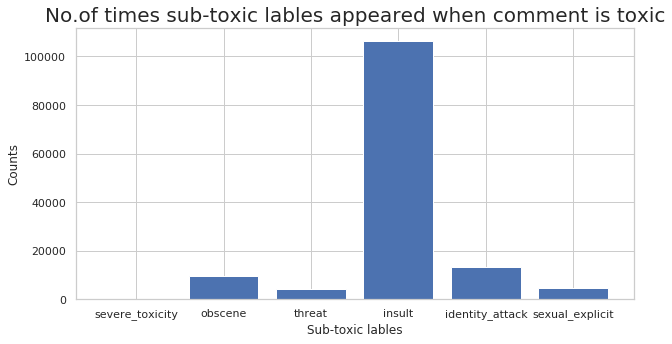

In [51]:
x1 = ['severe_toxicity', 'obscene', 'threat',
       'insult', 'identity_attack', 'sexual_explicit']

y1= [data.query('severe_toxicity == 1').shape[0],
     data.query('obscene == 1').shape[0],
     data.query('threat == 1').shape[0],
     data.query('insult == 1').shape[0],
     data.query('identity_attack == 1').shape[0],
     data.query('sexual_explicit == 1').shape[0],
    ]
     

plt.figure(figsize=(10,5))
plt.bar(x1, y1)
plt.title("No.of times sub-toxic lables appeared when comment is toxic",fontsize=20)
plt.xlabel("Sub-toxic lables")
plt.ylabel("Counts")
plt.xticks(x1)
plt.show()


#### From this plot we can interpret that most of the toxic comments have "insult" as sub-toxic type

In [52]:
print("The following result shows that no. of occurences that sub-toxic labels are appeared when comment is toxic: ")
tot =0
for i in y1:
    tot = i+tot 
tot

The following result shows that no. of occurences that sub-toxic labels are appeared when comment is toxic: 


138480

### Checking identity attributes attributes

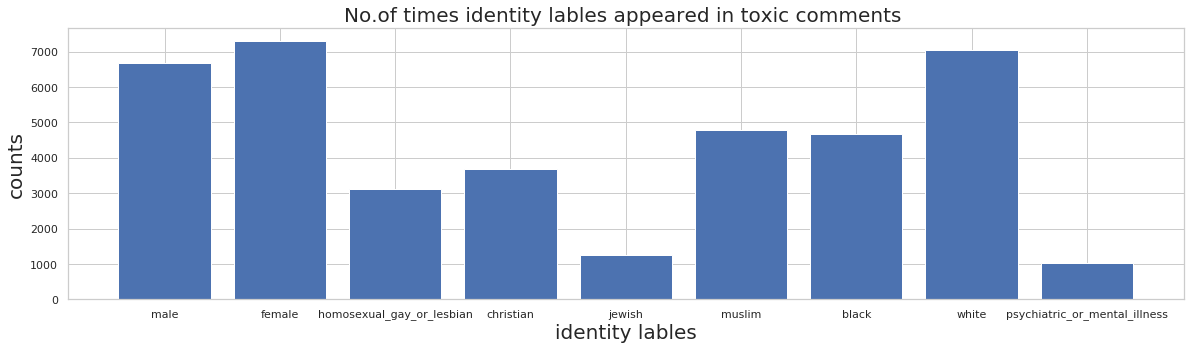

In [53]:
x1 = ['male', 'female',
       'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black',
       'white', 'psychiatric_or_mental_illness']

y1= [data.query('target==1 & male == 1').shape[0],
     data.query('target==1 & female == 1').shape[0],
     data.query('target==1 & homosexual_gay_or_lesbian == 1').shape[0],
     data.query('target==1 & christian == 1').shape[0],
     data.query('target==1 & jewish == 1').shape[0],
     data.query('target==1 & muslim == 1').shape[0],
     data.query('target==1 & black == 1').shape[0],
     data.query('target==1 & white == 1').shape[0],
     data.query('target==1 & psychiatric_or_mental_illness == 1').shape[0],
    ]
     

plt.figure(figsize=(20,5))
plt.bar(x1, y1)
plt.title("No.of times identity lables appeared in toxic comments ",fontsize=20)
plt.xlabel("identity lables",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.xticks(x1)
plt.show()


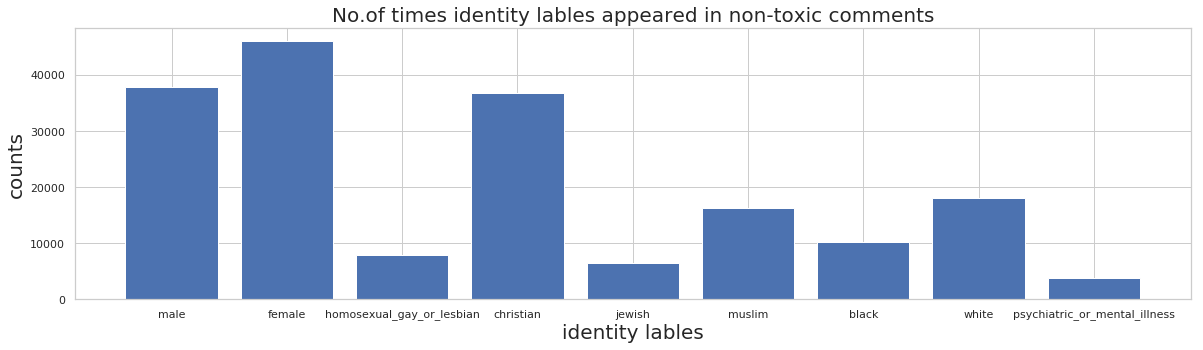

In [54]:
x1 = ['male', 'female',
       'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black',
       'white', 'psychiatric_or_mental_illness']

y1= [data.query('target==0 & male == 1').shape[0],
     data.query('target==0 & female == 1').shape[0],
     data.query('target==0 & homosexual_gay_or_lesbian == 1').shape[0],
     data.query('target==0 & christian == 1').shape[0],
     data.query('target==0 & jewish == 1').shape[0],
     data.query('target==0 & muslim == 1').shape[0],
     data.query('target==0 & black == 1').shape[0],
     data.query('target==0 & white == 1').shape[0],
     data.query('target==0 & psychiatric_or_mental_illness == 1').shape[0],
    ]
     

plt.figure(figsize=(20,5))
plt.bar(x1, y1)
plt.title("No.of times identity lables appeared in non-toxic comments",fontsize=20)
plt.xlabel("identity lables",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.xticks(x1)
plt.show()


#### From above plot we can interpret foe each label like the following example:

##### "There are nearly 8000 observations where "homosexual_gay_or_lesbian" are identified in the comments that are not really toxic".

similarlly we can understand same for every label. 

<h3>Now checking "comment_text"</h3>

In [55]:
print(data['comment_text'].iloc[100])
print("---------------------------------------------------------------------------")
print(data['comment_text'].iloc[50])
print("---------------------------------------------------------------------------")
print(data['comment_text'].iloc[250])
print("---------------------------------------------------------------------------")
print(data['comment_text'].iloc[666])

This post is bad, and you should feel bad! (\/) (°,,,°) (\/)
---------------------------------------------------------------------------
Star Trek is our future, Star Wars is our past. Vision versus history. Both are important!
---------------------------------------------------------------------------
Author of article here. I appreciate this fact-check, but 1977 can't be right, because John Williams was born in 1977: https://en.wikipedia.org/wiki/John_B

How could he have composed the music if he wasn't born yet? At age 5 or 6 though, it would definitely be possible (look at Mozart, for example).
---------------------------------------------------------------------------
They're not all wrong, though. Yeah, your numbers are a lot of what I've been seeing, but I live near Belmont and Cesar Chavez and my 1bdr 1bath apartment is $900/mo while the 1bdr apartment across the street from me is $950/mo and another I looked at in the area was around $950/mo last year. So they most definitely 

###### From the above comments we see that there are punctuations, urls, special characters, numbers, and contracted phase like I've etc.,  while preprocessing we need to clean all these text   

<h2>2. Text Preprocessing</h2>

In [56]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [57]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# we are including them into stop words list


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
"""References : 1. remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
             2. remove spacial character: https://stackoverflow.com/a/5843547/4084039
             3. https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
"""
                
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(data['comment_text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
joblib.dump(preprocessed_reviews,"preprocessed_reviews.pkl")

In [61]:
#preprocessed_reviews=joblib.load("preprocessed_reviews.pkl")

In [62]:
print(preprocessed_reviews[100])
print("---------------------------------------------------------------------------")
print(preprocessed_reviews[50])
print("---------------------------------------------------------------------------")
print(preprocessed_reviews[250])
print("---------------------------------------------------------------------------")
print(preprocessed_reviews[666])

post bad feel bad
---------------------------------------------------------------------------
star trek future star wars past vision versus history important
---------------------------------------------------------------------------
author article appreciate fact check not right john williams born could composed music not born yet age though would definitely possible look mozart example
---------------------------------------------------------------------------
not wrong though yeah numbers lot seeing live near belmont cesar chavez apartment apartment across street another looked area around last year definitely exist kind shitty old


In [63]:
data['preprocessed_reviews'] = preprocessed_reviews

<h2>3. Feature Engineering </h2>

<h5>From the available preproceesed feature i.e "comment_text", Let us try to build some new features </h5>

<h5> Here I am using "better-profanity 0.5.0" an open source library to record profanity in the comments</h5>

<h6>!pip install better-profanity 


Ref:https://pypi.org/project/better-profanity/


For list of words in profinity please refer below github link

https://github.com/RobertJGabriel/Google-profanity-words/blob/master/list.txt </h6>




In [64]:
from better_profanity import profanity
profanity.load_censor_words()

<h4> For example if we have comment like below :</h4> 

<h5> comment_Text = "This is a foolish thought, you guys are useless."</h5>

<h5> After preprocessing comment_text = "foolish thought guys useless" </h5>
 
 
 
<h5>
Then  our newly created features will be as follows.</h5>


<h5>
    
1. comment_length = 28


2. word_count = 4


3. num_bad_words = 2 -----> len(["foolish","useless"])


4. len_bad_words = 14 -----> len("foolish")+len("useless")


5. profinity_frequency = (a(num_bad_words) / (word_count)) = a(2)/4 = 2.5 (if a=5)


6. profinity_len_frequency = (a(comment_length) / (len_bad_words)) = a(28)/14 = 10


7. profinity_mul = (profinity_frequency)* (profinity_len_frequency) = 25


8. profinity_sum = (profinity_frequency)+ (profinity_len_frequency) = 12.5


9. profinity_HM = (profinity_mul) / (profinity_sum) = 2.0

</h5>

In [ ]:
word_count = [] #New feature 1 
comment_length=[] # New feature 2
for sentence in tqdm(preprocessed_reviews):
    word_count.append(len(sentence.split()))
    comment_length.append(len(sentence.strip()))

In [66]:
#adding some other negative words to profinity class
#all of these words are collected using google dictonary
extra_words= ['crap','stupid','idiotic','hate','dislike','grumpy', 'reject', 'remove', 'kill','disagreeable','sexy',
 'sexual','nasty','slave','idiot','curse','cursing','devil','monster','pervert','sadism','kick','kicking',
'useless', 'worthless', 'valueless','foolish','dishonestly','dishonest','fooled','loosers','loosig','loose',"psycho",
 'witless', 'brainless', 'mindless','kiss','kisses','kissed',"impotent", 'thoughtless', 'imprudent', 'incautious', 'irresponsible', 
 'injudicious','indiscreet', 'unwise', 'unwanted','hated','unintelligent','ruthlessness', 'unreasonable','impolitic', 'rash', 'reckless', 
 'foolhardy', 'lunatic', 'absurd', 'senseless', 'pointless', 'nonsensical', 'inane', 'fatuous', 'ridiculous', 
 'laughable','shame','lame','risible', 'derisible','dumb','deaf','blind','dim', 'witted', 'dopey', 'gormless', 'damfool', 
 'crackbrained','thickheaded', 'nutty', 'mad','madness','crazy','crazyness','psychopath','psychotic','warn','warning',
 'war','weapons','dangerous','danger','beware','caution','die','death','egoistic','jealous','lol',
 'suspicious','suspect','jealousy','timid','hell','weird','affair','unpleasant','troublesome', 
 'annoying', 'irritating', 'vexatious', 'displeasing', 'uncomfortable', 'distressing', 
 'nasty', 'horrible', 'appalling', 'terrible', 'awful', 'dreadful',"hate", 'hateful', 'detestable', 
 'miserable', 'abominable', 'execrable', 'odious', 'invidious', 'objecting', 'offensive', 
 'obnoxious', 'repugnant', 'repulsive', 'repellent', 'revolting', 'disgusting', 'distasteful', 
 'nauseating', 'unsavoury', 'unpalatable','ugly','blame','shame',"shameful"]

profanity.add_censor_words(extra_words)

In [67]:
def profanity_check(corpus):   
    num_bad_words =[] # count no.of bad words in the comment
    len_bad_words = [] # count no.of chars in bad words  in each comment 
    for sentence in tqdm(corpus):
        count=0
        for word in sentence.split(): 
            length = 0
            censored_text = profanity.contains_profanity(word)
            if censored_text==True:
                count = count+1
                length = len(word)+length
        num_bad_words.append(count)
        len_bad_words.append(length)
    return num_bad_words,len_bad_words 

In [ ]:
num_bad_words,len_bad_words= profanity_check(corpus=preprocessed_reviews) # New feature 3 and feature 4

In [69]:
data['word_count']=word_count
data['comment_length']=comment_length
data['num_bad_words']=num_bad_words
data['len_bad_words']=len_bad_words

In [70]:
data[data['word_count']==0].shape[0]

3634

In [71]:
data[data['comment_length']==0].shape[0]

3634

#### This number '3634' states that no. of points with out any text after preprocessing. 


Priting some of those points  

In [72]:
data[data['preprocessed_reviews']==''][['comment_text','preprocessed_reviews']].head(10)

,comment_text,preprocessed_reviews
33188,101th!,
115876,101th!,
33172,But you just did.,
115866,But you just did.,
115822,;),
33283,;),
140,Me too!,
269,www.businessinsider.com/it-turns-out-that-smok...,
276,:(,
615,http://www.tacticalshit.com/,


In [73]:
#Removing that kind of points
data = data[data['preprocessed_reviews']!='']

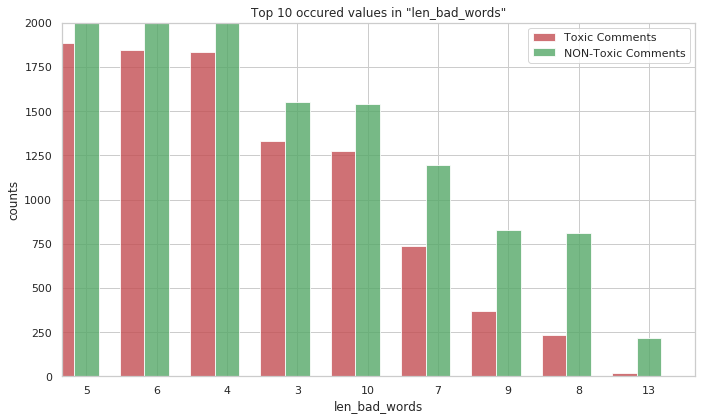

In [84]:
top = 10

y1 = (data[data['target']==1].len_bad_words.value_counts().head(top)).values
y2 = (data[data['target']==0].len_bad_words.value_counts().head(top)).values

bar_width = 0.35
opacity = 0.8

x1 = (data[data['target']==1].len_bad_words.value_counts().head(top)).index

index = np.arange(len(x1))

plt.figure(figsize=(10,6))
plt.bar(index, y1,bar_width,alpha=opacity,color='r',label='Toxic Comments')

plt.bar(index+bar_width,y2,bar_width,alpha=opacity,color='g',label='NON-Toxic Comments')

plt.title("Top {} occured values in \"len_bad_words\"".format(top))
plt.xlabel("len_bad_words")
plt.ylabel("counts")
plt.xticks(index + bar_width,x1)
plt.xlim(1,None)
plt.ylim(0,2000)
plt.legend()
plt.tight_layout()
plt.show()

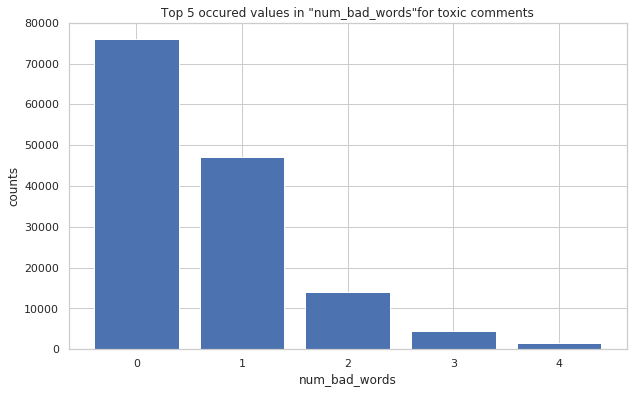

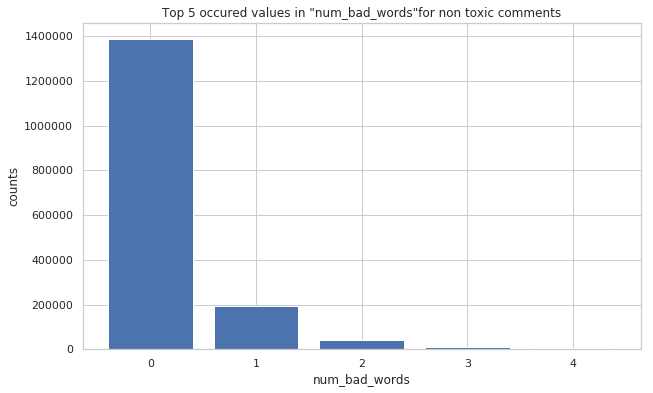

In [87]:
top = 5
y1 = (data[data['target']==1].num_bad_words.value_counts().head(top)).values
x1 = (data[data['target']==1].num_bad_words.value_counts().head(top)).index
plt.figure(figsize=(10,6))
plt.bar(x1, y1)
plt.title("Top {} occured values in \"num_bad_words\"for toxic comments".format(top))
plt.xlabel("num_bad_words")
plt.ylabel("counts")
plt.xticks(x1)
#plt.xlim(1, None)
plt.show()

top = 5
y1 = (data[data['target']==0].num_bad_words.value_counts().head(top)).values
x1 = (data[data['target']==0].num_bad_words.value_counts().head(top)).index
plt.figure(figsize=(10,6))
plt.bar(x1, y1)
plt.title("Top {} occured values in \"num_bad_words\"for non toxic comments".format(top))
plt.xlabel("num_bad_words")
plt.ylabel("counts")
plt.xticks(x1)
#plt.xlim(1, None)
plt.show()

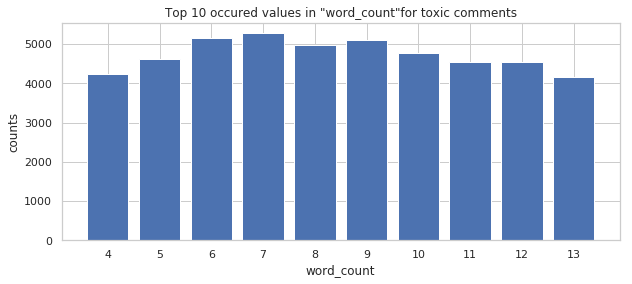

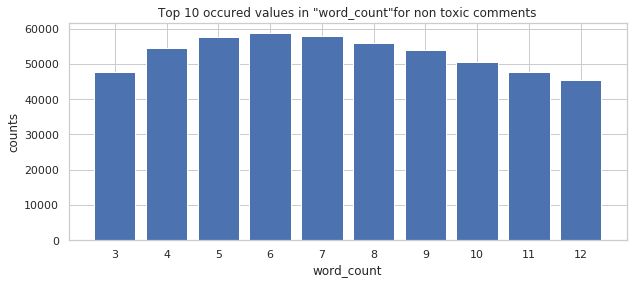

In [89]:
top = 10
y1 = (data[data['target']==1].word_count.value_counts().head(top)).values
x1 = (data[data['target']==1].word_count.value_counts().head(top)).index
plt.figure(figsize=(10,4))
plt.bar(x1, y1)
plt.title("Top {} occured values in \"word_count\"for toxic comments".format(top))
plt.xlabel("word_count")
plt.ylabel("counts")
plt.xticks(x1)
plt.show()

top = 10
y1 = (data[data['target']==0].word_count.value_counts().head(top)).values
x1 = (data[data['target']==0].word_count.value_counts().head(top)).index
plt.figure(figsize=(10,4))
plt.bar(x1, y1)
plt.title("Top {} occured values in \"word_count\"for non toxic comments".format(top))
plt.xlabel("word_count")
plt.ylabel("counts")
plt.xticks(x1)
plt.show()

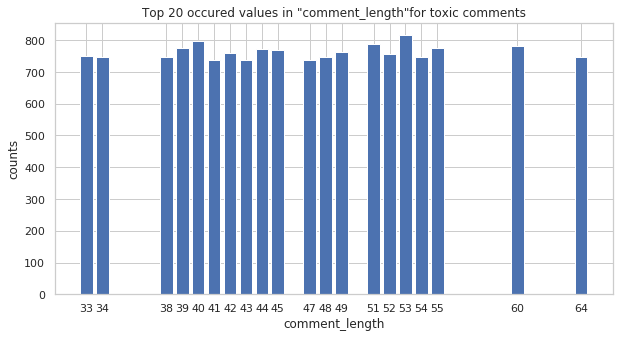

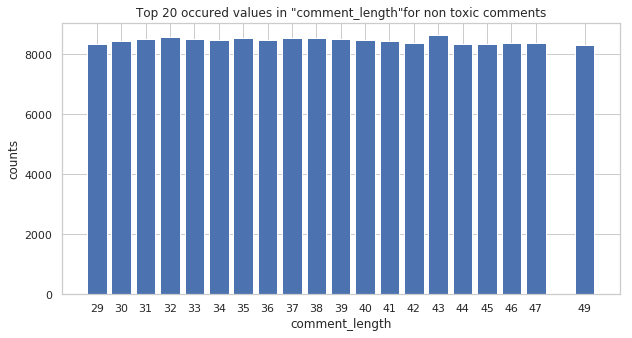

In [57]:
top = 20
y1 = (data[data['target']==1].comment_length.value_counts().head(top)).values
x1 = (data[data['target']==1].comment_length.value_counts().head(top)).index
plt.figure(figsize=(10,5))
plt.bar(x1, y1)
plt.title("Top {} occured values in \"comment_length\"for toxic comments".format(top))
plt.xlabel("comment_length")
plt.ylabel("counts")
plt.xticks(x1)
plt.show()

top = 20
y1 = (data[data['target']==0].comment_length.value_counts().head(top)).values
x1 = (data[data['target']==0].comment_length.value_counts().head(top)).index
plt.figure(figsize=(10,5))
plt.bar(x1, y1)
plt.title("Top {} occured values in \"comment_length\"for non toxic comments".format(top))
plt.xlabel("comment_length")
plt.ylabel("counts")
plt.xticks(x1)
plt.show()

"comment_length" and "word_count" has some what similar distributions. Let us derive some more features using these new ones   

<h4>Building profinity based features</h4>

<h4>profinity_frequency = (a*(num_bad_words+alpha) / (word_count)) </h4>

Where     
      a : some scaling factor

alpha : very samall value helps to overcome the zeros   

In [90]:
a = 5
data["profinity_frequency"] = a*(data['num_bad_words'].values)/(data['word_count'].values)  


In [91]:
a = 5
data["profinity_len_frequency"] = a*(data['len_bad_words'].values)/(data['comment_length'].values)  

data["profinity_mul"] = data["profinity_len_frequency"].values * data["profinity_frequency"].values

data["profinity_sum"] = data["profinity_len_frequency"].values + data["profinity_frequency"].values

data["profinity_HM"] = data["profinity_mul"].values/(data["profinity_sum"].values) 

In [92]:
data['profinity_HM'].isnull().sum()

1464582

These Null values are formed because of zero division. so filling these values with zero

In [93]:
data=data.fillna(0)

<h4>3.1 Exploring profinity based features </h4>

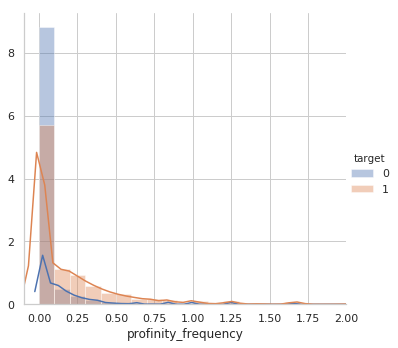

In [94]:
sns.FacetGrid(data, hue="target",size=5) \
   .map(sns.distplot,"profinity_frequency",kde= True) \
   .add_legend();
plt.xlim(-0.1,2)
plt.show();

#### We can see "profinity_frequency" feature has higher likelyhoods for the toxic comments.

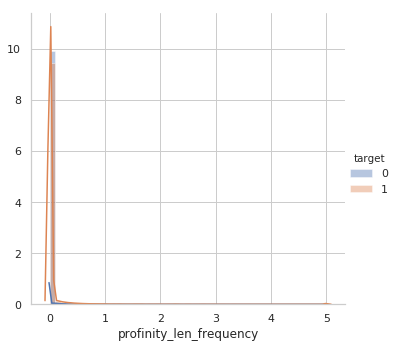

In [109]:
sns.FacetGrid(data, hue="target",size=5) \
   .map(sns.distplot,"profinity_len_frequency",kde= True) \
   .add_legend();
plt.show();

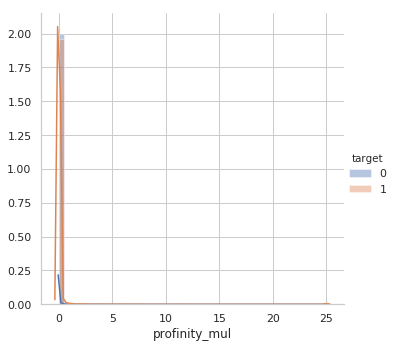

In [110]:
sns.FacetGrid(data, hue="target",size=5) \
   .map(sns.distplot,"profinity_mul",kde= True) \
   .add_legend();
plt.show();

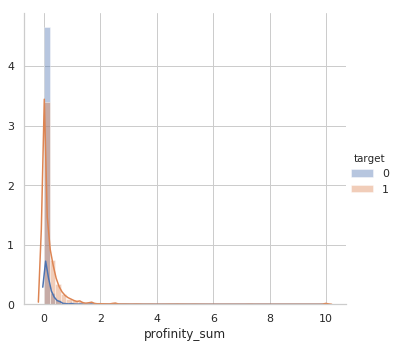

In [111]:
sns.FacetGrid(data, hue="target",size=5) \
   .map(sns.distplot,"profinity_sum",kde= True) \
   .add_legend();
#plt.xlim(-0.1*1e8,1*1e8)
plt.show();

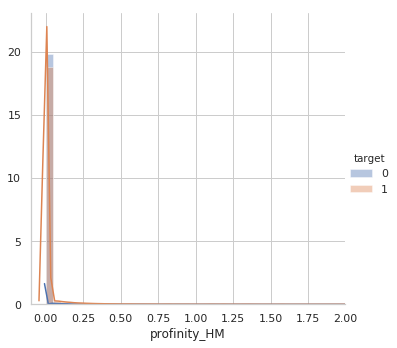

In [112]:
sns.FacetGrid(data, hue="target",size=5) \
   .map(sns.distplot,"profinity_HM",kde= True) \
   .add_legend();
plt.xlim(-0.1,2)
plt.show();

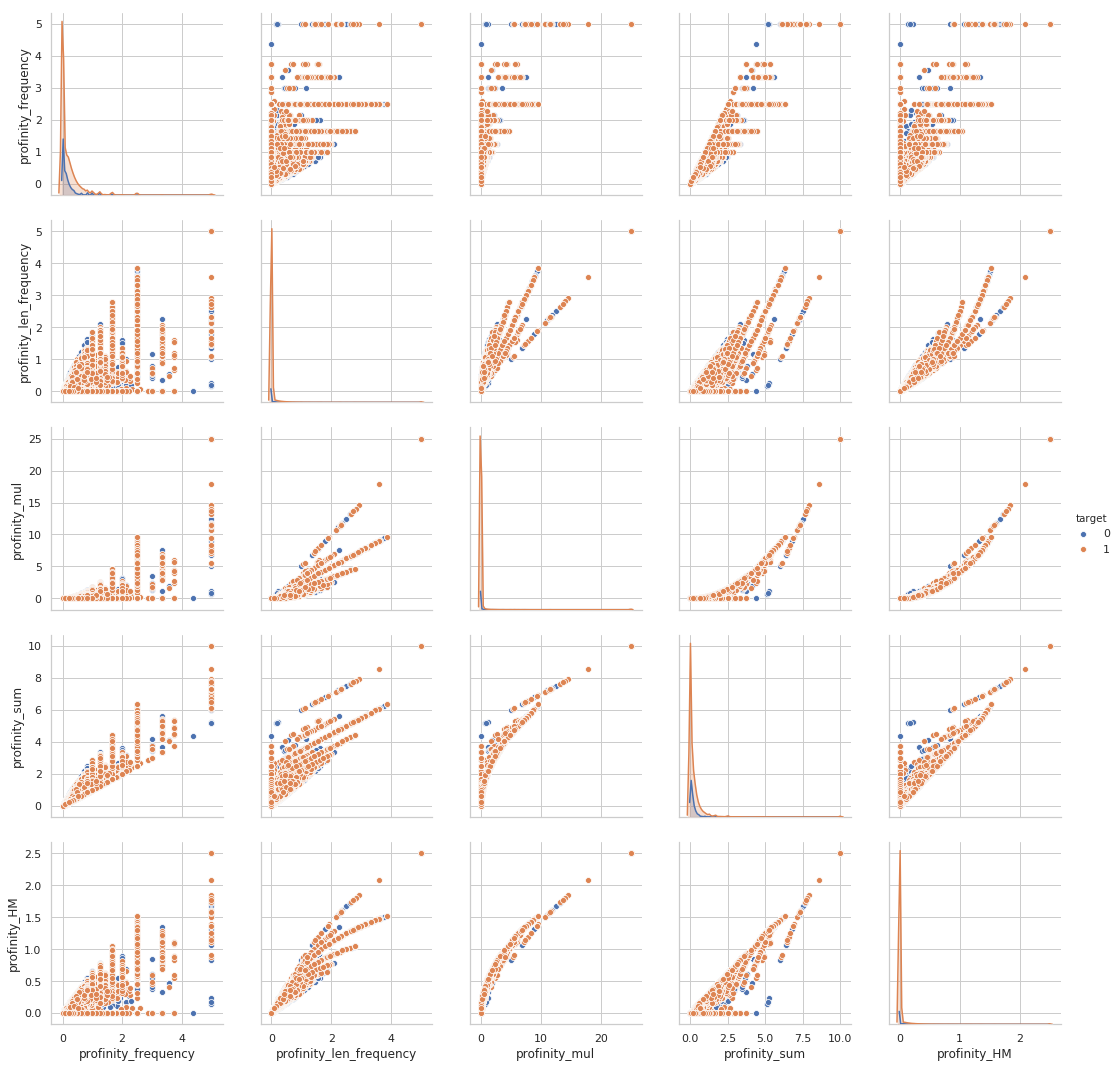

In [113]:
sns.set_style("whitegrid");

sns.pairplot(data,vars=["profinity_frequency","profinity_len_frequency","profinity_mul","profinity_sum",'profinity_HM'],hue='target',size=3);
plt.show()

#### In above pair plots we can see the density of toxic comments is more than the density of non-toxic comments,   

### Saving all this prepared data, so that we can use this modeling  

In [114]:
data=data.drop(['comment_text'],axis=1)
data.to_csv('data_processed.csv',index=False)